In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import gmaps
from apikey import g_key

In [2]:
file_path="bicycle-crash-data-chapel-hill-region.csv"
file_df=pd.read_csv(file_path,delimiter=';')

file_df.head()



,geo_point_2d,Ambulance,BikeAge,BikeAgeGrp,BikeAlcDrg,BikeAlcFlg,BikeDir,BikeInjury,BikePos,BikeRace,...,RdConditio,RdConfig,RdDefects,RdFeature,RdSurface,RuralUrban,SpeedLimit,TraffCntrl,Weather,Workzone
0,"33.9437020597,-78.3493385901",Yes,70,70+,No,No,With Traffic,C: Possible Injury,Travel Lane,White,...,Dry,"Two-Way, Not Divided",None,No Special Feature,Coarse Asphalt,Rural,40 - 45 MPH,No Control Present,Clear,No
1,"35.3217726,-79.0388423701",Yes,8,6-10,No,No,With Traffic,C: Possible Injury,Travel Lane,White,...,Dry,"Two-Way, Not Divided",None,T-Intersection,Smooth Asphalt,Rural,50 - 55 MPH,Stop Sign,Clear,No
2,"35.77105009,-78.6073184803",Yes,13,11-15,No,No,Facing Traffic,A: Suspected Serious Injury,Travel Lane,Black,...,Dry,"Two-Way, Divided, Positive Median Barrier",None,No Special Feature,Coarse Asphalt,Urban,30 - 35 MPH,Stop And Go Signal,Cloudy,No
3,"35.9394515202,-77.7953706304",Yes,52,50-59,No,No,Facing Traffic,C: Possible Injury,Travel Lane,Black,...,Dry,"One-Way, Not Divided",None,Four-Way Intersection,Coarse Asphalt,Urban,30 - 35 MPH,Stop And Go Signal,Clear,No
4,"36.0927628197,-80.2653764398",Yes,27,25-29,No,No,Not Applicable,C: Possible Injury,Non-Roadway,White,...,Dry,"Two-Way, Not Divided",None,No Special Feature,Smooth Asphalt,Urban,30 - 35 MPH,"Double Yellow Line, No Passing Zone",Clear,No


TREND 1 ANALYSIS - EFFECT OF WEATHER ON CRASH COUNT AND CRASH SEVERITY 

1.CREATE A NEW DF WITH WEATHER AND CRASH SEVERITY COLUMNS
2.DATA CLEANING  - RENAMING OF COLUMNS TO MAKE SENSE
3.GROUPBY DATA ON WEATHER TO GET CRASH COUNT ON EACH WEATHER VALUE

DEDUCTION - MAXIMUM CRASHES REPORTED OCCURED IN CLEAR WEATHER

In [3]:
weather_df = file_df[['CrashSevr','Weather']]
weather_df.columns=['Crash Severity','Weather']
weather_df.head()

,Crash Severity,Weather
0,C: Possible Injury,Clear
1,C: Possible Injury,Clear
2,A: Suspected Serious Injury,Cloudy
3,C: Possible Injury,Clear
4,C: Possible Injury,Clear


In [5]:
weather_group= weather_df.groupby(['Weather']).count()
weather_group.columns=['Crash Count']
weather_group.sort_values(by='Crash Count',ascending=False)


,Crash Count
Weather,
Clear,9286
Cloudy,1438
Rain,484
"Fog, Smog, Smoke",24
Other,19
"Snow, Sleet, Hail, Freezing Rain/Drizzle",15


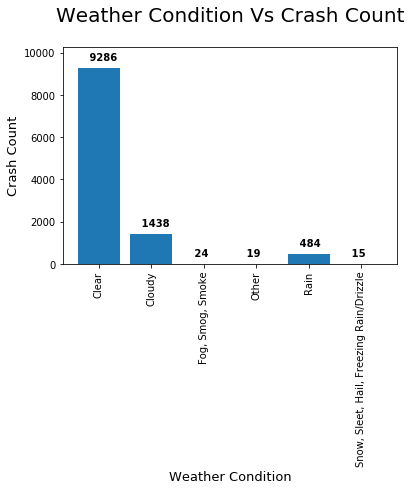

In [6]:
x=len(weather_group)
x_axis=np.arange(x)
y_axis= weather_group['Crash Count']
weather = weather_group.index

plt.bar(x_axis,y_axis)

tick_locations = [value for value in x_axis ]
plt.xticks(tick_locations, weather, rotation="vertical")

plt.xlabel("Weather Condition",fontdict={'fontsize':13})
plt.ylabel("Crash Count",fontdict={'fontsize':13})
plt.title("Weather Condition Vs Crash Count",fontdict={'fontsize':20},pad=25)
plt.ylim(0, max(y_axis)+1000)

for x, y in enumerate(y_axis):
    plt.text(x-0.25, y+500, " "+str(y), color='black', va='center', fontweight='bold')

plt.savefig("Images/Weather Condition Vs Crash Count.png",bbox_inches='tight')

plt.show()



In [7]:
weather_group_crash= weather_df.groupby(['Weather','Crash Severity']).agg({'Crash Severity': 'count'})
weather_group_crash.columns = ['Crash Count']
weather_group_crash

Crash Count
Weather                                  Crash Severity                          
Clear                                    A: Suspected Serious Injury          485
                                         B: Suspected Minor Injury           3921
                                         C: Possible Injury                  3556
                                         K: Killed                            207
                                         O: No Injury                        1060
                                         Unknown Injury                        57
Cloudy                                   A: Suspected Serious Injury           72
                                         B: Suspected Minor Injury            571
                                         C: Possible Injury                   583
                                         K: Killed                             38
                                         O: No Injury                         163
                                         Unknown Injury                        11
Fog, Smog, Smoke                         A: Suspected Serious Injury            2
                                         B: Suspected Minor Injury              5
                                         C: Possible Injury                     9
                                         K: Killed                              5
                                         O: No Injury                           3
Other                                    B: Suspected Minor Injury             11
                                         C: Possible Injury                     5
                                         O: No Injury                           3
Rain                                     A: Suspected Serious Injury           29
                                         B: Suspected Minor Injury            186
                                         C: Possible Injury                   208
                                         K: Killed                              8
                                         O: No Injury                          51
                                         Unknown Injury                         2
Snow, Sleet, Hail, Freezing Rain/Drizzle A: Suspected Serious Injury            1
                                         B: Suspected Minor Injury              2
                                         C: Possible Injury                     8
                                         K: Killed                              1
                                         O: No Injury                           3

Create a dataframe with weather=clear only and Road condition,Crash severity for further analysis
Renamed the columns in the dataframe
Grouped/Replaced redundant values - Water(Standing,Moving) and Wet
Grouping the clear_weather_df based on Road condition,Crash severity/ Road Condition alone


In [8]:
clear_weather_df = file_df.loc[(file_df['Weather']=='Clear'),['Weather','RdConditio','CrashSevr']]
clear_weather_df.columns=['Weather','Road Condition','Crash Severity']

clear_weather_df['Road Condition']=clear_weather_df['Road Condition'].replace({'Water (Standing, Moving)' :'Wet'})



clear_weather_group= clear_weather_df.groupby(['Road Condition']).count()
clear_weather_group

clear_weather_group=clear_weather_df.groupby(['Road Condition','Crash Severity']).agg({'Crash Severity': 'count'})
clear_weather_group.columns = ['Crash Count']
clear_weather_group

Crash Count
Road Condition          Crash Severity                          
Dry                     A: Suspected Serious Injury          476
                        B: Suspected Minor Injury           3872
                        C: Possible Injury                  3521
                        K: Killed                            205
                        O: No Injury                        1049
                        Unknown Injury                        55
Ice                     C: Possible Injury                     2
                        O: No Injury                           2
Sand, Mud, Dirt, Gravel A: Suspected Serious Injury            1
                        B: Suspected Minor Injury              3
                        C: Possible Injury                     1
Snow                    C: Possible Injury                     1
Unknown                 A: Suspected Serious Injury            1
                        B: Suspected Minor Injury             12
                        C: Possible Injury                     2
                        K: Killed                              1
                        O: No Injury                           1
                        Unknown Injury                         1
Wet                     A: Suspected Serious Injury            7
                        B: Suspected Minor Injury             34
                        C: Possible Injury                    29
                        K: Killed                              1
                        O: No Injury                           8
                        Unknown Injury                         1

TREND 2 ANALYSIS - EFFECT OF TRAFFIC CONTROL PRESENCE ON CRASH COUNTS

1.CREATE A DF WITH TRAFFIC CONTROL,CRASH SEVERITY
2.DATA CLEANING - RENAME COLUMN NAMES 
3.GROUPBY TRAFFIC CONTROL

DEDUCTION - MAXIMUM NUMBER OF REPORTED CRASHES HAPPENED WHERE THERE WAS NO TRAFFIC CONTROL PRESENT WHEN COMPARED TO HAVING TRAFFIC CONTROL.

In [9]:
traffic_df = file_df[['TraffCntrl','CrashSevr']]
traffic_df.columns=['Traffic Control','Crash Severity']

traffic_df_group= traffic_df.groupby(['Traffic Control']).count()

traffic_df_group.columns=['Crash Count']

traffic_df_group.sort_values(by='Crash Count',ascending=False)




,Crash Count
Traffic Control,
No Control Present,5152
Stop Sign,2341
Stop And Go Signal,2041
"Double Yellow Line, No Passing Zone",1372
Missing,153
Yield Sign,66
Other,50
Flashing Stop And Go Signal,34
Flashing Signal With Stop Sign,23


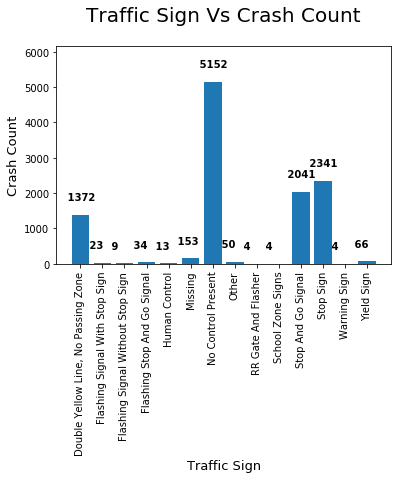

In [10]:
#PLOTTING -
x=len(traffic_df_group)
x_axis=np.arange(x)
y_axis= traffic_df_group['Crash Count']
traff_cntrl = traffic_df_group.index

plt.bar(x_axis,y_axis)

tick_locations = [value for value in x_axis ]
plt.xticks(tick_locations, traff_cntrl, rotation="vertical")

plt.xlabel("Traffic Sign",fontdict={'fontsize':13})
plt.ylabel("Crash Count",fontdict={'fontsize':13})
plt.title("Traffic Sign Vs Crash Count",fontdict={'fontsize':20},pad=25)

for x, y in enumerate(y_axis):
    plt.text(x-0.75, y+500, " "+str(y), color='black', va='center', fontweight='bold')

plt.ylim(0,max(y_axis)+1000)

plt.savefig("Images/Traffic Sign Vs Crash Count.png",bbox_inches='tight')
plt.show()

In [11]:
traffic_df_crash_group=traffic_df.groupby(['Traffic Control','Crash Severity']).agg({'Crash Severity':'count'})
traffic_df_crash_group.columns=['Crash Count']
traffic_df_crash_group

Crash Count
Traffic Control                     Crash Severity                          
Double Yellow Line, No Passing Zone A: Suspected Serious Injury          136
                                    B: Suspected Minor Injury            658
                                    C: Possible Injury                   416
                                    K: Killed                             67
                                    O: No Injury                          91
                                    Unknown Injury                         4
Flashing Signal With Stop Sign      A: Suspected Serious Injury            1
                                    B: Suspected Minor Injury             10
                                    C: Possible Injury                     8
                                    O: No Injury                           4
Flashing Signal Without Stop Sign   B: Suspected Minor Injury              3
                                    C: Possible Injury                     4
                                    O: No Injury                           2
Flashing Stop And Go Signal         B: Suspected Minor Injury             11
                                    C: Possible Injury                    16
                                    O: No Injury                           7
Human Control                       A: Suspected Serious Injury            2
                                    B: Suspected Minor Injury              4
                                    C: Possible Injury                     5
                                    O: No Injury                           2
Missing                             A: Suspected Serious Injury            5
                                    B: Suspected Minor Injury             61
                                    C: Possible Injury                    69
                                    K: Killed                              2
                                    O: No Injury                          16
No Control Present                  A: Suspected Serious Injury          265
                                    B: Suspected Minor Injury           2136
                                    C: Possible Injury                  1931
                                    K: Killed                            140
                                    O: No Injury                         637
                                    Unknown Injury                        43
Other                               A: Suspected Serious Injury            7
                                    B: Suspected Minor Injury             18
                                    C: Possible Injury                    19
                                    K: Killed                              1
                                    O: No Injury                           5
RR Gate And Flasher                 B: Suspected Minor Injury              2
                                    C: Possible Injury                     1
                                    O: No Injury                           1
School Zone Signs                   B: Suspected Minor Injury              3
                                    C: Possible Injury                     1
Stop And Go Signal                  A: Suspected Serious Injury           58
                                    B: Suspected Minor Injury            796
                                    C: Possible Injury                   896
                                    K: Killed                             19
                                    O: No Injury                         259
                                    Unknown Injury                        13
Stop Sign                           A: Suspected Serious Injury          112
                                    B: Suspected Minor Injury            964
                                    C: Possible Injury                   974
                                    K: Killed                

TREND 3 ANALYSIS - EFFECT OF ROAD CONFIGURATION FEATURE ON CRASH COUNTS

1.CREATE A DF WITH ROAD CONFIGURATION,CRASH SEVERITY
2.DATA CLEANING - RENAME COLUMN NAMES 
3.GROUPBY ROAD CONFIGURATION

DEDUCTION - MAXIMUM NUMBER OF REPORTED CRASHES HAPPENED WHERE THE ROAD CONFIGURATION IS "TWO-WAY,NOT DIVIDED"

In [12]:
rd_config_df = file_df[['RdConfig','CrashSevr']]
rd_config_df.columns=['Road Configuration','Crash Severity']

rd_config_df_group= rd_config_df.groupby(['Road Configuration']).count()

rd_config_df_group.columns=['Crash Count']

rd_config_df_group.sort_values(by='Crash Count',ascending=False)


,Crash Count
Road Configuration,
"Two-Way, Not Divided",8452
"Two-Way, Divided, Unprotected Median",1798
"One-Way, Not Divided",446
"Two-Way, Divided, Positive Median Barrier",436
Unknown,134


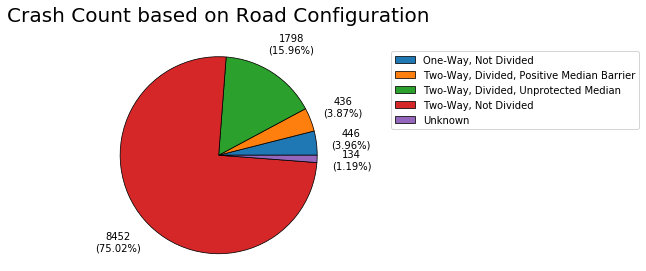

In [13]:
#Pie plot

labels=rd_config_df_group.index
sizes=rd_config_df_group['Crash Count']

plt.title("Crash Count based on Road Configuration",fontdict={'fontsize':20},pad=25)

plt.pie(sizes, autopct=lambda p:f'{p*sum(sizes)/100 :.0f}\n({p:.2f}%)', wedgeprops={'linewidth':0.75,'edgecolor':'black'},
        rotatelabels=True,textprops={'rotation': 0},pctdistance=1.35)
plt.axis("equal")
plt.legend(labels,bbox_to_anchor=(1,1))

plt.savefig("Images/Crash Count based on Road Configuration.png",bbox_inches='tight')

plt.show()


In [14]:
rd_config_df_crash=rd_config_df.groupby(['Road Configuration','Crash Severity']).agg({'Crash Severity':'count'})
rd_config_df_crash.columns=['Crash Count']
rd_config_df_crash

Crash Count
Road Configuration                        Crash Severity                          
One-Way, Not Divided                      A: Suspected Serious Injury           14
                                          B: Suspected Minor Injury            153
                                          C: Possible Injury                   200
                                          K: Killed                              5
                                          O: No Injury                          74
Two-Way, Divided, Positive Median Barrier A: Suspected Serious Injury           23
                                          B: Suspected Minor Injury            169
                                          C: Possible Injury                   182
                                          K: Killed                             10
                                          O: No Injury                          50
                                          Unknown Injury                         2
Two-Way, Divided, Unprotected Median      A: Suspected Serious Injury           80
                                          B: Suspected Minor Injury            724
                                          C: Possible Injury                   725
                                          K: Killed                             44
                                          O: No Injury                         210
                                          Unknown Injury                        15
Two-Way, Not Divided                      A: Suspected Serious Injury          468
                                          B: Suspected Minor Injury           3605
                                          C: Possible Injury                  3200
                                          K: Killed                            200
                                          O: No Injury                         928
                                          Unknown Injury                        51
Unknown                                   A: Suspected Serious Injury            4
                                          B: Suspected Minor Injury             45
                                          C: Possible Injury                    62
                                          O: No Injury                          21
                                          Unknown Injury                         2

In [15]:
#Rd class Vs Severity

rd_class_df = file_df[['RdClass','CrashSevr']]

rd_class_df.columns=['Road Class','Crash Severity']  

rd_class_df_new = rd_class_df.loc[(rd_class_df['Road Class'] != '.') , :]

rd_class_df_new                     

rd_class_df_new_group = rd_class_df_new.groupby(['Road Class']).count()

rd_class_df_new_group.columns=['Crash Count']

rd_class_df_new_group.sort_values(by='Crash Count',ascending=False)

,Crash Count
Road Class,
Local Street,6767
State Secondary Route,1742
NC Route,928
US Route,826
Public Vehicular Area,810
"Private Road, Driveway",82
missing,53
Interstate,29
Unknown,26


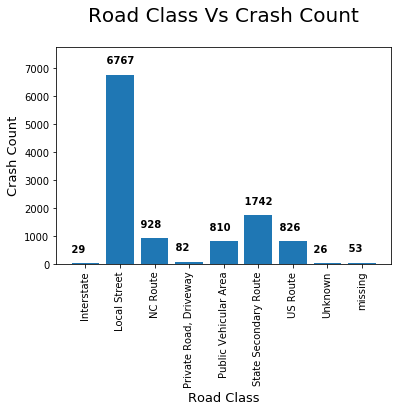

In [16]:
#Plotting

x=len(rd_class_df_new_group)
x_axis = np.arange(x)
y_axis=rd_class_df_new_group['Crash Count']
rd_class=rd_class_df_new_group.index

plt.bar(x_axis,y_axis)

tick_locations = [value for value in x_axis]
plt.xticks(tick_locations,rd_class,rotation='vertical')

plt.xlabel('Road Class',fontdict={'fontsize':13})
plt.ylabel('Crash Count',fontdict={'fontsize':13})
plt.title("Road Class Vs Crash Count",fontdict={'fontsize':20},pad=25)

for x, y in enumerate(y_axis):
    plt.text(x-0.5, y+500, " "+str(y), color='black', va='center', fontweight='bold')
plt.ylim(0,max(y_axis)+1000)
#plt.grid()

plt.savefig("Images/Road Class Vs Crash Count.png",bbox_inches='tight')
plt.show()


In [17]:
rd_class_df_crash=rd_class_df_new.groupby(['Road Class','Crash Severity']).agg({'Crash Severity':'count'})
rd_class_df_crash.columns=['Crash Count']
rd_class_df_crash

Crash Count
Road Class             Crash Severity                          
Interstate             A: Suspected Serious Injury            2
                       B: Suspected Minor Injury              7
                       C: Possible Injury                    15
                       K: Killed                              2
                       O: No Injury                           3
Local Street           A: Suspected Serious Injury          239
                       B: Suspected Minor Injury           2815
                       C: Possible Injury                  2751
                       K: Killed                             79
                       O: No Injury                         832
                       Unknown Injury                        51
NC Route               A: Suspected Serious Injury           86
                       B: Suspected Minor Injury            391
                       C: Possible Injury                   313
                       K: Killed                             53
                       O: No Injury                          83
                       Unknown Injury                         2
Private Road, Driveway A: Suspected Serious Injury            3
                       B: Suspected Minor Injury             26
                       C: Possible Injury                    36
                       K: Killed                              2
                       O: No Injury                          14
                       Unknown Injury                         1
Public Vehicular Area  A: Suspected Serious Injury           18
                       B: Suspected Minor Injury            268
                       C: Possible Injury                   374
                       K: Killed                              1
                       O: No Injury                         146
                       Unknown Injury                         3
State Secondary Route  A: Suspected Serious Injury          169
                       B: Suspected Minor Injury            810
                       C: Possible Injury                   549
                       K: Killed                             77
                       O: No Injury                         128
                       Unknown Injury                         9
US Route               A: Suspected Serious Injury           68
                       B: Suspected Minor Injury            355
                       C: Possible Injury                   297
                       K: Killed                             45
                       O: No Injury                          59
                       Unknown Injury                         2
Unknown                A: Suspected Serious Injury            2
                       B: Suspected Minor Injury              8
                       C: Possible Injury                     6
                       O: No Injury                           9
                       Unknown Injury                         1
missing                A: Suspected Serious Injury            2
                       B: Suspected Minor Injury             16
                       C: Possible Injury                    27
                       O: No Injury                           7
                       Unknown Injury                         1

In [18]:
hotspot_df = file_df[['geo_point_2d','City','County']]
hotspot_df

hotspot_df_clean=hotspot_df.loc[(hotspot_df['City'] != 'None - Rural Crash'),:]
hotspot_df_clean

,geo_point_2d,City,County
2,"35.77105009,-78.6073184803",Raleigh,Wake
3,"35.9394515202,-77.7953706304",Rocky Mount,Edgecombe
4,"36.0927628197,-80.2653764398",Winston-Salem,Forsyth
5,"35.7588841497,-78.6400827003",Raleigh,Wake
7,"35.0993177701,-77.0791913495",New Bern,Craven
...,...,...,...
11260,"34.2309800801,-77.8780524702",Wilmington,New Hanover
11261,"34.2546581498,-77.9197554903",Wilmington,New Hanover
11262,"35.2123611203,-80.7913412696",Charlotte,Mecklenburg
11263,"35.64331907,-80.4828223001",Salisbury,Rowan


In [19]:
hotspot_df_test = hotspot_df_clean.groupby(['County']).agg({'County':'count'})

hotspot_df_test.columns=['Crash Count']


hotspot_df_test.reset_index(inplace=True)

hotspot_df_test.sort_values(by='Crash Count',ascending=False)

,County,Crash Count
49,Mecklenburg,1401
80,Wake,1378
33,Guilford,675
54,New Hanover,631
26,Durham,500
...,...,...
5,Bertie,1
3,Avery,1
13,Caswell,1
2,Ashe,1


In [34]:
hotspot_df_test['Latitude'] = ""
hotspot_df_test['Longitude'] = ""

target_type = 'administrative_area_level_2'

params = {'key' : g_key,
          'types': target_type}

for index, row in hotspot_df_test.iterrows():
    base_url = "https://maps.googleapis.com/maps/api/geocode/json"
    
    current_county = row['County']
    
    params['address'] = f"{current_county},North Carolina"
    
    #print(params)
    response = requests.get(base_url, params=params) 
    
    data = response.json()
    #pprint(data,indent =4)
    
    x = data['results'][0]['geometry']['location']['lat']
    y = data['results'][0]['geometry']['location']['lng']
    hotspot_df_test.loc[index,"Latitude"] = x
    hotspot_df_test.loc[index,"Longitude"] = y
    
hotspot_df_test.head()

,County,Crash Count,Latitude,Longitude
0,Alamance,102,36.0351,-79.4859
1,Anson,8,34.9055,-80.1875
2,Ashe,1,36.434,-81.4718
3,Avery,1,36.1198,-81.9098
4,Beaufort,37,34.7182,-76.6638


In [35]:
gmaps.configure(api_key=g_key)

locations = hotspot_df_test[["Latitude", "Longitude"]].astype(float)

crashcount = hotspot_df_test["Crash Count"].astype(float)

In [36]:
fig = gmaps.figure()
heat_layer = gmaps.heatmap_layer(locations, weights=crashcount, 
                                 dissipating=False, max_intensity=1000,
                                 point_radius = 0.25)
fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [37]:
# Create crash city symbol layer

crash_rate = hotspot_df_test["Crash Count"].tolist()
county_name = hotspot_df_test["County"].tolist()

crash_rate_str = hotspot_df_test["Crash Count"].astype(str)


crash_layer = gmaps.symbol_layer(
    locations, fill_color='rgba(0, 150, 0, 0.4)',
    stroke_color='rgba(0, 0, 150, 0.4)', scale=2,
    hover_text=crash_rate_str,info_box_content=[f"County: {Value}" for Value in county_name])

fig = gmaps.figure()
fig.add_layer(crash_layer)
fig


Figure(layout=FigureLayout(height='420px'))

In [38]:
#Create Combined map

fig = gmaps.figure()
fig.add_layer(heat_layer)
fig.add_layer(crash_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [33]:
import gmaps.geojson_geometries

crash_rate = hotspot_df_test["Crash Count"].tolist()
county_name = hotspot_df_test["County"].tolist()
crash_rate_str = hotspot_df_test["Crash Count"].astype(str)

countries_geojson = gmaps.geojson_geometries.load_geometry('us-states')
county_geojson = gmaps.geojson_geometries.load_geometry('us-counties')

fig = gmaps.figure()

geojson_country = gmaps.geojson_layer(countries_geojson,fill_opacity=0)
geojson_county = gmaps.geojson_layer(county_geojson,fill_opacity=0)

heat_layer = gmaps.heatmap_layer(locations, weights=crashcount, 
                                 dissipating=False, max_intensity=200,
                                 point_radius = 0.25)

crash_layer = gmaps.symbol_layer(
    locations, fill_color='rgba(0, 150, 0, 0.4)',
    stroke_color='rgba(0, 0, 150, 0.4)', scale=2,
    hover_text=crash_rate_str,info_box_content=[f"County: {Value}" for Value in county_name])

fig.add_layer(geojson_country)
fig.add_layer(geojson_county)
fig.add_layer(heat_layer)
fig.add_layer(crash_layer)

fig


Figure(layout=FigureLayout(height='420px'))